# Import and useful functions

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns

import statsmodels.formula.api as smf

from data import load_data_viz_data

In [2]:
# Haversine distance function
from math import radians, sin, cos, asin, sqrt

def haversine_distance(lon1, lat1, lon2, lat2):
    """
    Compute distance (km) between two pairs of (lat, lng) coordinates
    See - (https://en.wikipedia.org/wiki/Haversine_formula)
    """
    
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    
    a = sin(dlat / 2) ** 2 + cos(lat1) * cos(lat2) * sin(dlon / 2) ** 2
    
    return 2 * 6371 * asin(sqrt(a))

In [3]:
def add_crime_cat(data):
    data['crime_cat'] = pd.cut(data['NB_INCIDENTS'],
                               bins=4,
                               labels=['low', 'mid', 'mid-high', 'high']
                                )
    return data

In [4]:
def get_crime_data(drop_code=True):
    
    crime_data = pd.read_csv('https://wagon-public-datasets.s3.amazonaws.com/certification_france_2021_q2/boston_crimes_regression.csv').sort_values('NB_INCIDENTS', ascending = False)
    crime_data = crime_data.drop(columns='CODE').set_index('NAME')
    crime_data = add_crime_cat(crime_data)
    
    return crime_data.copy()

In [5]:
def get_incident_data():
    incident_data = load_data_viz_data().set_index('NAME')
    incident_data[['LAT','LONG']] = incident_data[['LAT','LONG']].astype('float64')
    incident_data['AVG_DISTANCE'] = incident_data.apply(lambda row: haversine_distance(row['LAT'], row['LONG'], \
                                                    row['LAT_POLICE_STATION'], row['LONG_POLICE_STATION']), axis=1)
    return incident_data

In [6]:
def get_full_df():
    crime_data = get_crime_data()
    incident_data = get_incident_data()
    return crime_data.join(incident_data.groupby('NAME')\
                           .agg({'AVG_DISTANCE': lambda x: np.round(np.mean(x), 3)}).copy(), on='NAME')

In [7]:
def get_high_crime_df(data):
    return data[(data['crime_cat']== 'high') |  (data['crime_cat']== 'mid-high')]
    
def get_low_crime_df(data):
    return data[(data['crime_cat']== 'low') |  (data['crime_cat']== 'mid')]

In [29]:
def plot_first_graph():
    plt.figure(figsize=(15, 8))

    ax = sns.barplot(y=data.index, x=data['NB_INCIDENTS'], data=data, orient='h', hue='crime_cat', palette='flare')

    ax.axes.set_title("Number of incidents between 2015 and 2019 in Boston by district",fontsize=30, pad = 30)
    ax.legend()
    ax.set_xlabel("Number of incidents",fontsize=20)
    ax.set_ylabel("Boston district",fontsize=20)
    

In [19]:
def plot_crim_graphs(data, high=True):
    
    fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(30, 10))
    
    if high:
        high_crim_df = get_high_crime_df(data)
        for column_name, ax in zip(sorted(list(high_crim_df.drop(columns='NB_INCIDENTS').columns)), axes.flatten()):
            ax.bar(x=high_crim_df.index, height=high_crim_df[column_name], color='darkorange', width = 0.4)
            ax.set_title(column_name)
        
        plt.show()
    
    low_crim_df = get_low_crime_df(data)

    for column_name, ax in zip(sorted(list(low_crim_df.drop(columns='NB_INCIDENTS').columns)), axes.flatten()):
        ax.bar(x=low_crim_df.index, height=low_crim_df[column_name], color='blue', width = 0.4)
        ax.set_title(column_name)    

In [20]:
def plot_dist_graphs(data, high=True):
    
    plt.figure(figsize=(20, 10))

    ax = sns.barplot(x=data.index, y=data['AVG_DISTANCE'], data=data, orient='v', hue='crime_cat', palette='flare')

    ax.axes.set_title("Average distance in km between police station and place of crime in km",fontsize=30, pad = 30)
    ax.legend(title="Level of criminality", fontsize = 'large')
    ax.set_xlabel("Boston district",fontsize=20)
    ax.set_ylabel("Average distance in km",fontsize=20)

# Boston crime data 

## How to explain criminality in Boston? June 29 2021

In [21]:
data = get_full_df()
data

,MEDIAN_AGE,TOTAL_POP,PERC_OF_30_34,PERC_MARRIED_COUPLE_FAMILY,PER_CAPITA_INCOME,PERC_OTHER_STATE_OR_ABROAD,PERC_LESS_THAN_HIGH_SCHOOL,PERC_COLLEGE_GRADUATES,NB_INCIDENTS,crime_cat,AVG_DISTANCE
NAME,,,,,,,,,,,
Roxbury,32.5,54161,27.8,17.8,20978,2.9,23.0,18.9,38877,high,2.666
Dorchester,33.4,126909,28.2,26.6,29767,2.4,18.0,17.1,32875,high,2.730
South End,37.1,32571,33.9,28.3,83609,6.2,11.8,8.5,31258,high,1.948
Mattapan,36.7,26659,20.9,29.8,28356,2.3,14.5,22.9,28331,mid-high,1.605
Downtown,33.5,18306,32.5,35.8,80057,14.8,15.4,6.9,26260,mid-high,5.982
South Boston,31.9,36772,46.1,24.7,64745,2.4,7.9,8.4,16617,mid,30.836
Brighton,30.8,55297,52.8,26.4,41261,8.6,6.7,10.5,13788,mid,3.903
Jamaica Plain,34.8,40867,32.5,33.7,51655,5.5,8.0,12.1,12802,low,2.170
Hyde Park,39.4,38924,21.1,38.4,32744,1.9,13.8,21.3,12551,low,1.861


### First, let us have a look at how violence is spread across Boston districts

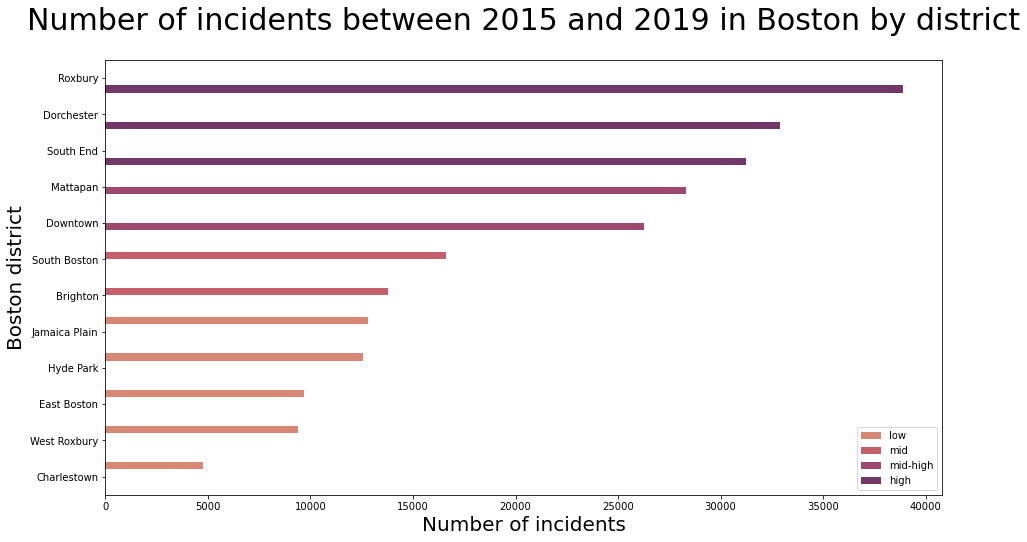

In [30]:
plot_first_graph()

**Remark**: we can clearly see that all districts are not affected in the same way by violence. The districts of **Roxbury**, **Dorchester** and **South End** are particularly affected by crime, with more  than **29000 incidents** over the past 5 years.

### Let's now have a deeper look at these districts that have different criminality levels. Let's start with the most violent districts.

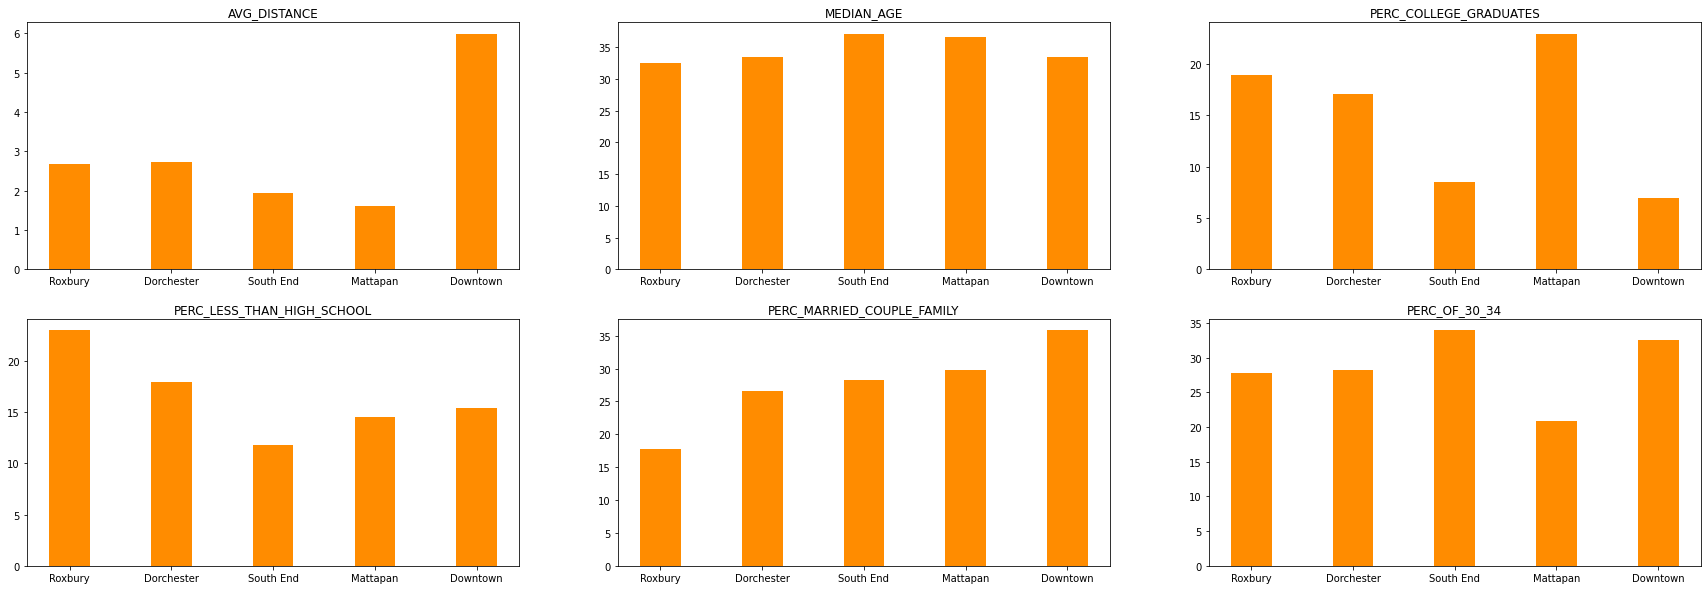

In [23]:
plot_crim_graphs(data, high=True)

**Remark**: here we can notice that the most dangerous districts (Roxbury and Dorchester) tend to have a younger population, with a large proportion of high school dropouts (>20%), and a much lower rate of married couples.

### How about less violent ones?

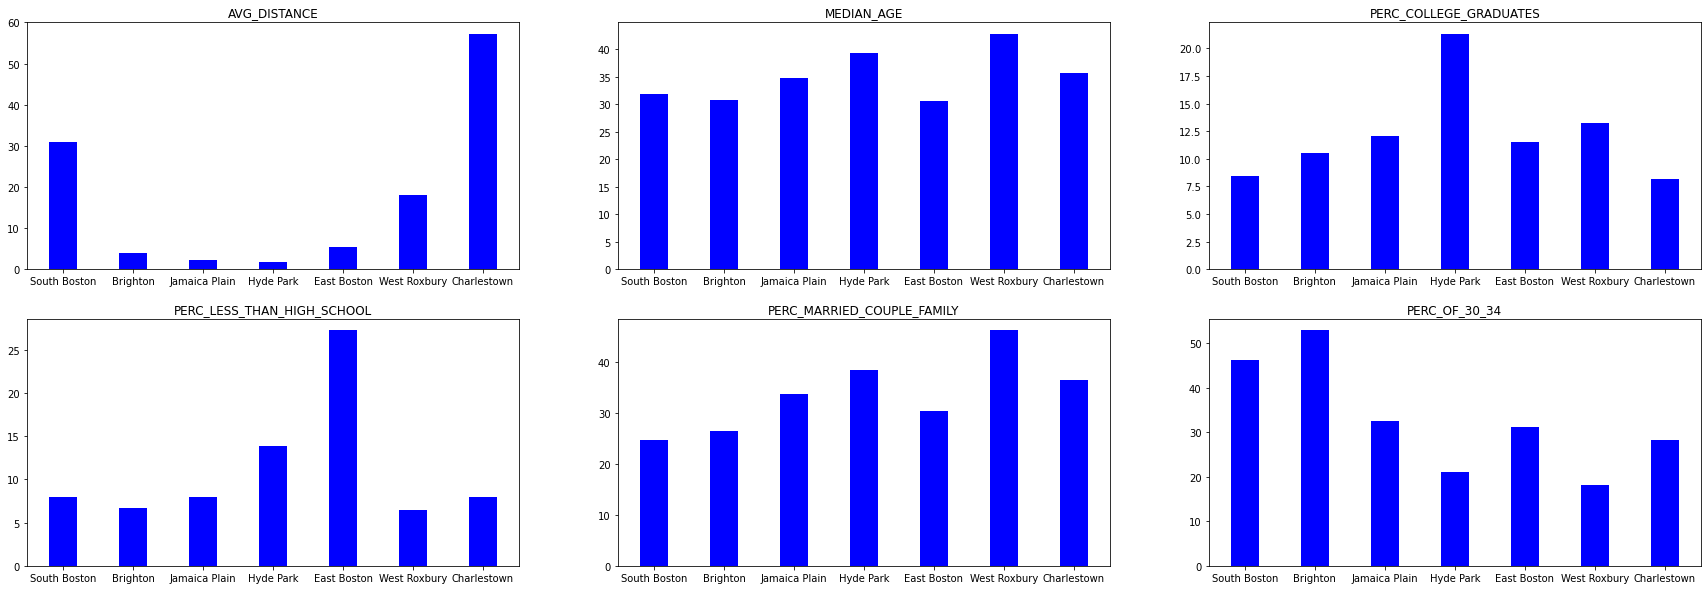

In [25]:
plot_crim_graphs(data, high=False)

**Remark**: On the other hand, districts with lower figures of violence exhibit totally different characteristics: their population tends to be older, a larger share have graduated from college and are married.

**Conclusion**: Age, education level and marriage seem to provide personal stability, hence reducing violence across districts.

### Lastly, let's check what is the average distance between the act of violence and the closest police station.

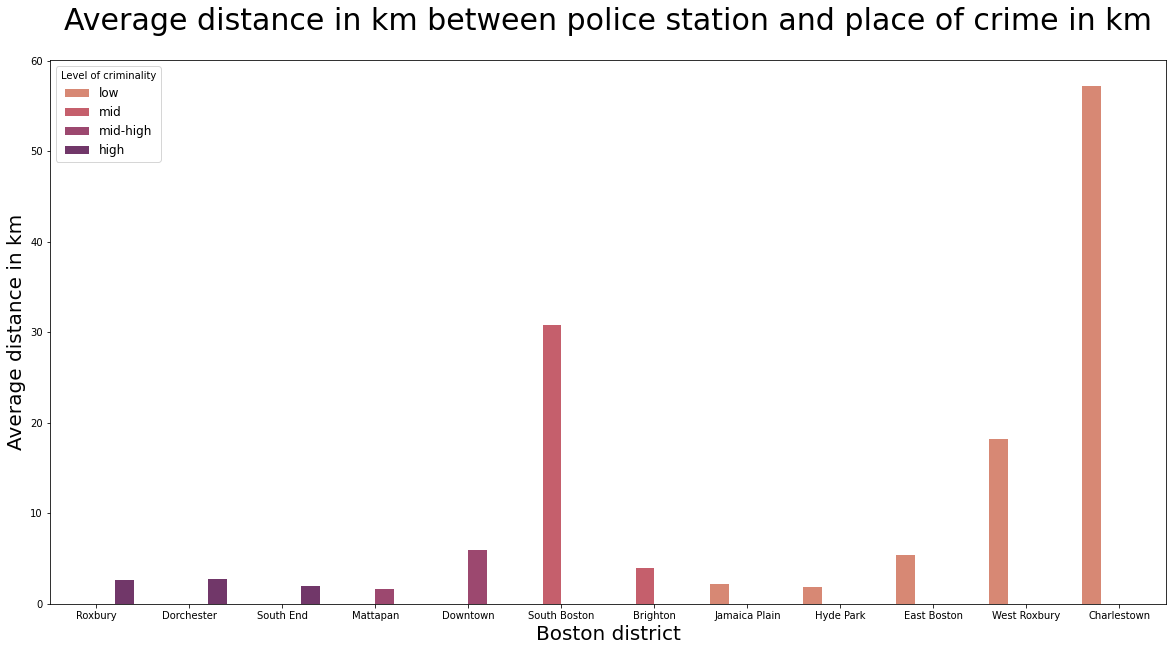

In [27]:
plot_dist_graphs(data)

Interestingly, the most violent districts have a smaller distance between place of violence and the police station. It  suggests that police presence might enhance violence even more, or that some behaviours are more tackled around police stations in some districts.